In [59]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [60]:
df_visitor = pd.read_excel("visitor.xlsx")


In [61]:
df_visitor

,Year,Week,Mt. Baw Baw,Mt. Stirling,Mt. Hotham,Falls Creek,Mt. Buller,Selwyn,Thredbo,Perisher,Charlotte Pass
0,2014,1,555,60,3483,2790,8296,1041,5535,7370,408
1,2014,2,804,42,1253,1425,1987,383,2090,2751,151
2,2014,3,993,30,2992,2101,2413,597,3216,4255,230
3,2014,4,2976,165,9680,9544,18831,2877,15497,20265,1134
4,2014,5,11112,645,29628,26211,49217,8588,46546,61339,3403
...,...,...,...,...,...,...,...,...,...,...,...
160,2024,11,5977,1416,24260,38541,43387,6859,37608,49136,2667
161,2024,12,3597,701,19289,42101,36668,5969,33208,43382,2392
162,2024,13,1500,213,14487,25252,15415,3351,18120,23908,1323
163,2024,14,0,0,2700,17137,0,1177,6270,8244,454


In [62]:
df_visitor = df_visitor.melt(
    id_vars=["Year", "Week"],     
    var_name="Resort",            
    value_name="Number of visitors"             
)

print(df_visitor.head())

   Year  Week       Resort  Number of visitors
0  2014     1  Mt. Baw Baw                 555
1  2014     2  Mt. Baw Baw                 804
2  2014     3  Mt. Baw Baw                 993
3  2014     4  Mt. Baw Baw                2976
4  2014     5  Mt. Baw Baw               11112


In [63]:
import numpy as np
df_visitor["Number of visitors"] = df_visitor["Number of visitors"].replace(0, np.nan)
df_visitor["Number of visitors"] = df_visitor.groupby(["Resort", "Week"])["Number of visitors"] \
                                         .transform(lambda x: x.fillna(x.mean()))

In [64]:
df_1 = pd.read_excel("weather.xlsx")

In [65]:
import pandas as pd

df_test = df_1.copy()  
df_test["Date"] = pd.to_datetime(df_test[["Year", "Month", "Day"]])
week_ranges = {
    1: ("06-09", "06-15"),
    2: ("06-16", "06-22"),
    3: ("06-23", "06-29"),
    4: ("06-30", "07-06"),
    5: ("07-07", "07-13"),
    6: ("07-14", "07-20"),
    7: ("07-21", "07-27"),
    8: ("07-28", "08-03"),
    9: ("08-04", "08-10"),
    10: ("08-11", "08-17"),
    11: ("08-18", "08-24"),
    12: ("08-25", "08-31"),
    13: ("09-01", "09-07"),
    14: ("09-08", "09-14"),
    15: ("09-15", "09-21")
}

def get_week(row):
    year = row["Year"]
    for wk, (start, end) in week_ranges.items():
        start_date = pd.to_datetime(f"{year}-{start}")
        end_date   = pd.to_datetime(f"{year}-{end}")
        if start_date <= row["Date"] <= end_date:
            return wk
    return None

df_test["Week"] = df_test.apply(get_week, axis=1)

weekly_weather = df_test.groupby(["Bureau of Meteorology station number","Year", "Week"]).agg({
    "Maximum temperature (Degree C)": "max",
    "Minimum temperature (Degree C)": "min",
    "Rainfall amount (millimetres)": "sum"
}).reset_index()

print(weekly_weather.head())

   Bureau of Meteorology station number  Year  Week  \
0                                 71032  2010     1   
1                                 71032  2010     2   
2                                 71032  2010     3   
3                                 71032  2010     4   
4                                 71032  2010     5   

   Maximum temperature (Degree C)  Minimum temperature (Degree C)  \
0                             3.1                            -7.0   
1                             1.9                            -6.6   
2                             2.7                            -9.1   
3                             1.5                            -7.6   
4                             4.7                            -9.5   

   Rainfall amount (millimetres)  
0                            1.8  
1                           44.8  
2                           44.4  
3                            0.6  
4                           45.6  


In [66]:
for col in ['Maximum temperature (Degree C)', 'Minimum temperature (Degree C)', 'Rainfall amount (millimetres)']:
    weekly_weather[col] = weekly_weather.groupby(['Bureau of Meteorology station number', 'Week'])[col].transform(lambda x: x.fillna(x.mean()))

weekly_weather.isnull().sum()

Bureau of Meteorology station number    0
Year                                    0
Week                                    0
Maximum temperature (Degree C)          0
Minimum temperature (Degree C)          0
Rainfall amount (millimetres)           0
dtype: int64

In [67]:
def predict(week_data, variable_name):
    years = sorted(week_data['Year'].unique())
    epsilons = []
    for i in range(len(years) - 2):
        mean_prev = np.mean([week_data[week_data['Year'] == years[i]][variable_name].iloc[0],
                             week_data[week_data['Year'] == years[i + 1]][variable_name].iloc[0]])
        epsilon = (week_data[week_data['Year'] == years[i + 2]][variable_name].iloc[0] - mean_prev)
        epsilons.append(epsilon)
    epsilon_mean = np.mean(epsilons) if epsilons else 0
    mean_2_prevs = np.mean([week_data[week_data['Year'] == years[-2]][variable_name].iloc[0],
                              week_data[week_data['Year'] == years[-1]][variable_name].iloc[0]])
    predicted = mean_2_prevs + epsilon_mean
    return predicted

In [68]:
predicted_weather_2025 = []
for station in weekly_weather['Bureau of Meteorology station number'].unique():
    for week in range(9, 16):
        station_week_data = weekly_weather[(weekly_weather['Bureau of Meteorology station number'] == station) & (weekly_weather['Week'] == week)]
        if len(station_week_data) >= 3:
            max_temp = predict(station_week_data, 'Maximum temperature (Degree C)')
            min_temp = predict(station_week_data, 'Minimum temperature (Degree C)')
            rainfall = predict(station_week_data, 'Rainfall amount (millimetres)')
            new_row = {
                'Bureau of Meteorology station number': station,
                'Year': 2025,
                'Week': week,
                'Maximum temperature (Degree C)': max_temp,
                'Minimum temperature (Degree C)': min_temp,
                'Rainfall amount (millimetres)': rainfall,

            }
            predicted_weather_2025.append(new_row)

weather = pd.concat([weekly_weather, pd.DataFrame(predicted_weather_2025)], ignore_index=True)

predicted_weather_2026 = []
for station in weather['Bureau of Meteorology station number'].unique():
    for week in range(1, 16):
        station_week_data = weather[(weather['Bureau of Meteorology station number'] == station) & (weather['Week'] == week)]
        if len(station_week_data) >= 3:
            max_temp = predict(station_week_data, 'Maximum temperature (Degree C)')
            min_temp = predict(station_week_data, 'Minimum temperature (Degree C)')
            rainfall = predict(station_week_data, 'Rainfall amount (millimetres)')
            if rainfall < 0: rainfall = 0
            new_row = {
                'Bureau of Meteorology station number': station,
                'Year': 2026,
                'Week': week,
                'Maximum temperature (Degree C)': max_temp,
                'Minimum temperature (Degree C)': min_temp,
                'Rainfall amount (millimetres)': rainfall,

            }
            predicted_weather_2026.append(new_row)

df_weather_2026 = pd.DataFrame(predicted_weather_2026)
df_weather_2026

,Bureau of Meteorology station number,Year,Week,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
0,71032,2026,1,4.067857,-6.689286,21.242857
1,71032,2026,2,3.746429,-7.200000,0.000000
2,71032,2026,3,2.521429,-7.485714,12.828571
3,71032,2026,4,3.721429,-9.225000,20.371429
4,71032,2026,5,3.989286,-5.282143,12.007143
...,...,...,...,...,...,...
100,85291,2026,11,10.021154,-0.861538,34.961538
101,85291,2026,12,10.617308,-1.611538,29.657692
102,85291,2026,13,13.394231,-3.707692,49.884615
103,85291,2026,14,14.138462,-2.042308,37.211538


In [69]:
df_weather_2026[(df_weather_2026['Bureau of Meteorology station number'] == 85291) & (df_weather_2026['Week'] == 10)]

,Bureau of Meteorology station number,Year,Week,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
99,85291,2026,10,11.063462,-0.488462,0.0


In [70]:
predicted_visitation_2025 = []
for resort in df_visitor['Resort'].unique():
    for week in range(1, 16):
        resort_week_data = df_visitor[(df_visitor['Resort'] == resort) & (df_visitor['Week'] == week)]
        if len(resort_week_data) >= 3:
            number_of_visitors = predict(resort_week_data, 'Number of visitors')
            new_row = {
                'Year': 2025,
                'Week': week,
                'Resort': resort,
                'Number of visitors': number_of_visitors
            }
            predicted_visitation_2025.append(new_row)

df_visitor = pd.concat([df_visitor, pd.DataFrame(predicted_visitation_2025)], ignore_index=True)

predicted_visitation_2026 = []
for resort in df_visitor['Resort'].unique():
    for week in range(1, 16):
        resort_week_data = df_visitor[(df_visitor['Resort'] == resort) & (df_visitor['Week'] == week)]
        if len(resort_week_data) >= 3:
            number_of_visitors = int(predict(resort_week_data, 'Number of visitors'))
            new_row = {
                'Year': 2026,
                'Week': week,
                'Resort': resort,
                'Number of visitors': number_of_visitors
            }
            predicted_visitation_2026.append(new_row)

df_visitation_2026 = pd.DataFrame(predicted_visitation_2026)

station_map = {"Thredbo": 71032,
    "Charlotte Pass": 71075,
    "Mt. Buller": 83024,
    "Perisher": 71075,
    "Falls Creek": 83084,
    "Mt. Hotham": 83085,
    "Mt. Stirling": 83024,
    "Selwyn": 72161,
    "Mt. Baw Baw": 85291
}

df_visitation_2026['Bureau of Meteorology station number'] = df_visitation_2026["Resort"].map(station_map)
            

In [71]:
df_visitation_2026

,Year,Week,Resort,Number of visitors,Bureau of Meteorology station number
0,2026,1,Mt. Baw Baw,1257,85291
1,2026,2,Mt. Baw Baw,1826,85291
2,2026,3,Mt. Baw Baw,3556,85291
3,2026,4,Mt. Baw Baw,9084,85291
4,2026,5,Mt. Baw Baw,13001,85291
...,...,...,...,...,...
130,2026,11,Charlotte Pass,2507,71075
131,2026,12,Charlotte Pass,2188,71075
132,2026,13,Charlotte Pass,1041,71075
133,2026,14,Charlotte Pass,203,71075


In [72]:
weekly_weather.head(10)

,Bureau of Meteorology station number,Year,Week,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
0,71032,2010,1,3.1,-7.0,1.8
1,71032,2010,2,1.9,-6.6,44.8
2,71032,2010,3,2.7,-9.1,44.4
3,71032,2010,4,1.5,-7.6,0.6
4,71032,2010,5,4.7,-9.5,45.6
5,71032,2010,6,1.8,-8.7,99.4
6,71032,2010,7,5.8,-8.5,0.6
7,71032,2010,8,5.1,-5.3,11.6
8,71032,2010,9,3.6,-10.4,0.0
9,71032,2010,10,3.4,-7.2,0.0


In [73]:
predicted_data_2026 = df_visitation_2026.merge(df_weather_2026,  on=["Year", "Week", "Bureau of Meteorology station number"],
    how="inner")

predicted_data_2026 = predicted_data_2026.drop(columns=["Bureau of Meteorology station number"])
predicted_data_2026.head(10)

,Year,Week,Resort,Number of visitors,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
0,2026,1,Mt. Baw Baw,1257,3.742857,-1.960714,72.528571
1,2026,2,Mt. Baw Baw,1826,7.425000,-3.510714,10.507143
2,2026,3,Mt. Baw Baw,3556,6.842857,-3.171429,55.971429
3,2026,4,Mt. Baw Baw,9084,9.617857,-3.653571,97.150000
4,2026,5,Mt. Baw Baw,13001,8.300000,-1.775000,86.542857
5,2026,6,Mt. Baw Baw,9657,3.535714,-3.125000,118.642857
6,2026,7,Mt. Baw Baw,10009,4.714286,-2.914286,34.085714
7,2026,8,Mt. Baw Baw,8938,4.317857,-2.967857,36.142857
8,2026,9,Mt. Baw Baw,8842,7.501923,-1.494231,0.000000
9,2026,10,Mt. Baw Baw,7277,11.063462,-0.488462,0.000000


In [74]:
df_visitation_2026.head(10)

,Year,Week,Resort,Number of visitors,Bureau of Meteorology station number
0,2026,1,Mt. Baw Baw,1257,85291
1,2026,2,Mt. Baw Baw,1826,85291
2,2026,3,Mt. Baw Baw,3556,85291
3,2026,4,Mt. Baw Baw,9084,85291
4,2026,5,Mt. Baw Baw,13001,85291
5,2026,6,Mt. Baw Baw,9657,85291
6,2026,7,Mt. Baw Baw,10009,85291
7,2026,8,Mt. Baw Baw,8938,85291
8,2026,9,Mt. Baw Baw,8842,85291
9,2026,10,Mt. Baw Baw,7277,85291


In [75]:
predicted_data_2026.head(10)

,Year,Week,Resort,Number of visitors,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
0,2026,1,Mt. Baw Baw,1257,3.742857,-1.960714,72.528571
1,2026,2,Mt. Baw Baw,1826,7.425000,-3.510714,10.507143
2,2026,3,Mt. Baw Baw,3556,6.842857,-3.171429,55.971429
3,2026,4,Mt. Baw Baw,9084,9.617857,-3.653571,97.150000
4,2026,5,Mt. Baw Baw,13001,8.300000,-1.775000,86.542857
5,2026,6,Mt. Baw Baw,9657,3.535714,-3.125000,118.642857
6,2026,7,Mt. Baw Baw,10009,4.714286,-2.914286,34.085714
7,2026,8,Mt. Baw Baw,8938,4.317857,-2.967857,36.142857
8,2026,9,Mt. Baw Baw,8842,7.501923,-1.494231,0.000000
9,2026,10,Mt. Baw Baw,7277,11.063462,-0.488462,0.000000


In [76]:
len(predicted_data_2026)

135

In [77]:
score = pd.read_excel('scoring_metrics.xlsx', sheet_name = 'amenities_records') #Ammenities Calculation
df_general = pd.read_excel('scoring_metrics.xlsx', sheet_name = 'general_trend') #General Trend of the Past 10
df_holiday = pd.read_excel('scoring_metrics.xlsx', sheet_name = 'pub_holiday') #Holiday Schedule for the period

In [78]:
predicted_data_2026.rename(columns={"Week": "week"}, inplace=True)

In [79]:
#1 Add average temperature to main dataframes 
predicted_data_2026['average_temp'] = predicted_data_2026['Minimum temperature (Degree C)']/2 + (predicted_data_2026['Minimum temperature (Degree C)'] + predicted_data_2026['Maximum temperature (Degree C)'])/4
df_general['average_temp'] = df_general['min_temp']/2 + (df_general['min_temp'] + df_general['max_temp'])/4

#2 Add holiday count to holiday dataframe
# Add a holiday count (total events per week)
df_holiday["holiday_count"] = (
    df_holiday[["nsw_school", "vic_school", "act_school",
                "nsw_public", "vic_public", "act_public",
                "special_event"]].sum(axis=1)
)

In [80]:
# Ensure a lowercase 'week' key exists for the join
if "week" not in df_holiday.columns and "Week" in df_holiday.columns:
    df_holiday = df_holiday.rename(columns={"Week": "week"})

# Make sure week is int in df_holiday
df_holiday["week"] = df_holiday["week"].astype(int)

# --- Function to merge all holiday columns into a dataframe ---
def merge_holidays(df):
    df = df.copy()
    df["week"] = df["week"].astype(int)

    # Merge all columns from df_holiday
    df = df.merge(df_holiday, on="week", how="left", suffixes=("", "_h"))

    # Fill defaults for numeric holiday-related columns
    for col in df_holiday.columns:
        if col == "week":
            continue
        if pd.api.types.is_numeric_dtype(df_holiday[col]):
            df[col] = df[col].fillna(0)

    return df

# --- Apply to both datasets ---
predicted_data_2026 = merge_holidays(predicted_data_2026)
df_general = merge_holidays(df_general)

# --- Preview ---
print(df_general.head())

   year  week       resort  num_passenger  price  station  max_temp  min_temp  \
0  2014     1  Mt. Baw Baw          555.0     79    85291       7.3      -2.2   
1  2014     2  Mt. Baw Baw          804.0     79    85291       8.6      -1.0   
2  2014     3  Mt. Baw Baw          993.0     79    85291       2.5      -4.5   
3  2014     4  Mt. Baw Baw         2976.0     79    85291       6.2      -2.6   
4  2014     5  Mt. Baw Baw        11112.0     79    85291       4.7      -3.7   

        rain  average_temp         Dates  nsw_school  vic_school  act_school  \
0   3.485714         0.175      9–15 Jun           0           0           0   
1   3.000000         1.400     16–22 Jun           0           0           0   
2  12.733333        -2.750     23–29 Jun           0           1           0   
3  11.714286        -0.400  30 Jun–6 Jul           0           1           0   
4  11.800000        -1.600      7–13 Jul           1           1           1   

   nsw_public  vic_public  act_p

## Amenities Calculation

In [81]:
# Feature sets
higher_is_better = ["number_of_run","number_of_lift","total_ski_area","hotels_10km"]
lower_is_better  = ["price","min_distance_big_cities"]

# Safe min–max scaler
def minmax_series(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce") 
    smin, smax = s.min(), s.max()
    if pd.isna(smin) or pd.isna(smax) or smax == smin:
        return pd.Series(np.full(len(s), 0.5), index=s.index)  
    return (s - smin) / (smax - smin)

# --- Build 0–1 scores ---
score_cols = []

for col in higher_is_better:
    sc = minmax_series(score[col].fillna(0))
    score[f"{col}_score"] = sc
    score_cols.append(f"{col}_score")

for col in lower_is_better:
    sc = 1 - minmax_series(score[col].fillna(score[col].median()))
    score[f"{col}_score"] = sc
    score_cols.append(f"{col}_score")


# Or emphasize core ski infra:
weights = {
    "number_of_run_score": 0.20,
    "number_of_lift_score": 0.25,
    "total_ski_area_score": 0.15,
    "hotels_10km_score": 0.10,
    "price_score": 0.10,
    "min_distance_big_cities_score": 0.20,
}

# Normalize to sum 1 (safe even if you tweak values)
wsum = sum(weights.get(c, 0) for c in score_cols)
weights = {k: v / wsum for k, v in weights.items()}

# --- Amenity index & rank ---
score["amenities_scores"] = sum(score[c] * weights.get(c, 0) for c in score_cols)
score["AmenityRank"]  = score["amenities_scores"].rank(ascending=False, method="min").astype(int)


# correct column names here (amenities_scores, not AmenidtyIndex)
cols_show = [
    "id","name","price","number_of_run","number_of_lift","total_ski_area",
    "hotels_10km","min_distance_big_cities",
    "amenities_scores","AmenityRank"
]

df_display = score[cols_show].sort_values("amenities_scores", ascending=False).reset_index(drop=True)
df_display

,id,name,price,number_of_run,number_of_lift,total_ski_area,hotels_10km,min_distance_big_cities,amenities_scores,AmenityRank
0,6,Perisher,256,100,47,1245,993,190,0.881818,1
1,5,Mt. Buller,126,80,22,300,183,230,0.550496,2
2,3,Thredbo,209,53,16,480,310,210,0.470346,3
3,1,Mt. Baw Baw,79,25,7,35,39,180,0.386287,4
4,9,Selwyn,119,15,10,45,0,170,0.366014,5
5,7,Falls Creek,177,90,15,450,54,390,0.364075,6
6,2,Mt.Hotham,189,80,14,320,179,380,0.337993,7
7,4,Charlotte Pass,175,26,5,50,7,200,0.303815,8
8,8,Mt. Stirling,195,0,0,0,183,230,0.198347,9


In [82]:
#1) Load the amenities_scores sheet
path = "scoring_metrics.xlsx"
amen = pd.read_excel(path, sheet_name="amenities_scores")

# Keep only the columns you need
amen = amen[["name", "AmenityIndex"]].copy()
#2) Merge directly on exact name match
predicted_data_2026 = predicted_data_2026.copy()
predicted_data_2026 = predicted_data_2026.merge(amen, how="left", left_on="Resort", right_on="name")
#3) Sanity check for unmatched resorts
unmatched = predicted_data_2026.loc[predicted_data_2026["AmenityIndex"].isna(), ["Resort"]].drop_duplicates()
if len(unmatched):
    print("Resorts without AmenityIndex after merge:")
    print(unmatched)

In [83]:
#4) Drop duplicate 'name' column if not needed
predicted_data_2026.drop(columns=["name_y"], inplace=True, errors="ignore")

In [84]:
predicted_data_2026

,Year,week,Resort,Number of visitors,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),average_temp,Dates,nsw_school,vic_school,act_school,nsw_public,vic_public,act_public,special_event,holiday_count,name,AmenityIndex
0,2026,1,Mt. Baw Baw,1257,3.742857,-1.960714,72.528571,-0.534821,9–15 Jun,0,0,0,1,1,1,0,3,Mt. Baw Baw,0.386287
1,2026,2,Mt. Baw Baw,1826,7.425000,-3.510714,10.507143,-0.776786,16–22 Jun,0,0,0,0,0,0,0,0,Mt. Baw Baw,0.386287
2,2026,3,Mt. Baw Baw,3556,6.842857,-3.171429,55.971429,-0.667857,23–29 Jun,0,1,0,0,0,0,0,1,Mt. Baw Baw,0.386287
3,2026,4,Mt. Baw Baw,9084,9.617857,-3.653571,97.150000,-0.335714,30 Jun–6 Jul,0,1,0,0,0,0,0,1,Mt. Baw Baw,0.386287
4,2026,5,Mt. Baw Baw,13001,8.300000,-1.775000,86.542857,0.743750,7–13 Jul,1,1,1,0,0,0,0,3,Mt. Baw Baw,0.386287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,2026,11,Charlotte Pass,2507,9.476923,-4.494231,30.576923,-1.001442,18–24 Aug,0,0,0,0,0,0,0,0,Charlotte Pass,0.303815
131,2026,12,Charlotte Pass,2188,11.042308,-1.448077,83.165385,1.674519,25–31 Aug,0,0,0,0,0,0,0,0,Charlotte Pass,0.303815
132,2026,13,Charlotte Pass,1041,13.192308,-4.192308,20.450000,0.153846,1–7 Sep,0,0,0,0,0,0,1,1,Charlotte Pass,0.303815
133,2026,14,Charlotte Pass,203,16.944231,-6.092308,18.738462,-0.333173,8–14 Sep,0,0,0,0,0,0,0,0,Charlotte Pass,0.303815


In [85]:
predicted_data_2026.drop(columns=["amenities_scores_x"], inplace=True, errors="ignore")
predicted_data_2026.drop(columns=["amenities_scores_y"], inplace=True, errors="ignore")

In [86]:
predicted_data_2026.rename(columns={"name_x": "name"}, inplace=True)


In [87]:
predicted_data_2026

,Year,week,Resort,Number of visitors,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),average_temp,Dates,nsw_school,vic_school,act_school,nsw_public,vic_public,act_public,special_event,holiday_count,name,AmenityIndex
0,2026,1,Mt. Baw Baw,1257,3.742857,-1.960714,72.528571,-0.534821,9–15 Jun,0,0,0,1,1,1,0,3,Mt. Baw Baw,0.386287
1,2026,2,Mt. Baw Baw,1826,7.425000,-3.510714,10.507143,-0.776786,16–22 Jun,0,0,0,0,0,0,0,0,Mt. Baw Baw,0.386287
2,2026,3,Mt. Baw Baw,3556,6.842857,-3.171429,55.971429,-0.667857,23–29 Jun,0,1,0,0,0,0,0,1,Mt. Baw Baw,0.386287
3,2026,4,Mt. Baw Baw,9084,9.617857,-3.653571,97.150000,-0.335714,30 Jun–6 Jul,0,1,0,0,0,0,0,1,Mt. Baw Baw,0.386287
4,2026,5,Mt. Baw Baw,13001,8.300000,-1.775000,86.542857,0.743750,7–13 Jul,1,1,1,0,0,0,0,3,Mt. Baw Baw,0.386287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,2026,11,Charlotte Pass,2507,9.476923,-4.494231,30.576923,-1.001442,18–24 Aug,0,0,0,0,0,0,0,0,Charlotte Pass,0.303815
131,2026,12,Charlotte Pass,2188,11.042308,-1.448077,83.165385,1.674519,25–31 Aug,0,0,0,0,0,0,0,0,Charlotte Pass,0.303815
132,2026,13,Charlotte Pass,1041,13.192308,-4.192308,20.450000,0.153846,1–7 Sep,0,0,0,0,0,0,1,1,Charlotte Pass,0.303815
133,2026,14,Charlotte Pass,203,16.944231,-6.092308,18.738462,-0.333173,8–14 Sep,0,0,0,0,0,0,0,0,Charlotte Pass,0.303815


## Score Rule:

Correlation between avg temp and visitation: -0.333


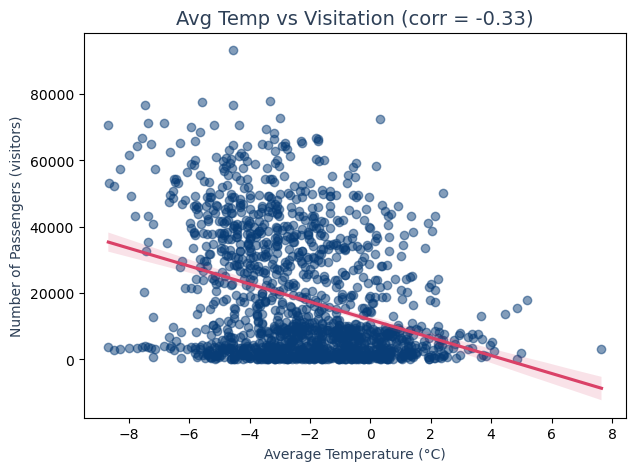

Correlation per resort:
resort
Charlotte Pass   -0.294107
Falls Creek      -0.148929
Mt. Baw Baw      -0.220481
Mt. Buller       -0.295626
Mt. Hotham       -0.238786
Mt. Stirling     -0.194832
Perisher         -0.297554
Selwyn           -0.310896
Thredbo          -0.327150
Name: (average_temp, num_passenger), dtype: float64


In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Correlation value
corr = df_general['average_temp'].corr(df_general['num_passenger'])
print(f"Correlation between avg temp and visitation: {corr:.3f}")

# 2) Scatterplot with trendline (using custom palette)
plt.figure(figsize=(7,5))
sns.regplot(
    data=df_general,
    x="average_temp",
    y="num_passenger",
    scatter_kws={'alpha':0.5, 'color':'#083D77'},   # Yale Blue points
    line_kws={'color':'#DA4167'}                    # Cerise line
)
plt.title(f"Avg Temp vs Visitation (corr = {corr:.2f})", fontsize=14, color="#2E4057")
plt.xlabel("Average Temperature (°C)", color="#2E4057")
plt.ylabel("Number of Passengers (visitors)", color="#2E4057")
plt.show()

# 3) Optionally: group by resort
corr_by_resort = (
    df_general.groupby("resort")[["average_temp","num_passenger"]]
    .corr()
    .unstack()
    .iloc[:,1]
)
print("Correlation per resort:")
print(corr_by_resort)

In [89]:
# Step 1: get Q3 threshold
q3_temp = predicted_data_2026["average_temp"].quantile(0.75)

# Step 2: max temp (for scaling penalty)
tmax = predicted_data_2026["average_temp"].max()

# Step 3: scoring function
def temp_score_rule(t, threshold=q3_temp, tmax=tmax):
    if t <= threshold:
        return 2.0
    # linear decline from threshold -> 2 pts down to tmax -> 0 pts
    return max(0.0, 2.0 * (1 - (t - threshold) / (tmax - threshold)))

# Apply
predicted_data_2026["temp_score"] = predicted_data_2026["average_temp"].apply(temp_score_rule)

# Preview
predicted_data_2026[["Resort","Year","week","average_temp","temp_score"]].head()

,Resort,Year,week,average_temp,temp_score
0,Mt. Baw Baw,2026,1,-0.534821,2.000000
1,Mt. Baw Baw,2026,2,-0.776786,2.000000
2,Mt. Baw Baw,2026,3,-0.667857,2.000000
3,Mt. Baw Baw,2026,4,-0.335714,2.000000
4,Mt. Baw Baw,2026,5,0.743750,1.670162


/var/folders/qb/1whh5bv901bb76kjzsnqrk2c0000gn/T/ipykernel_27829/2537108277.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


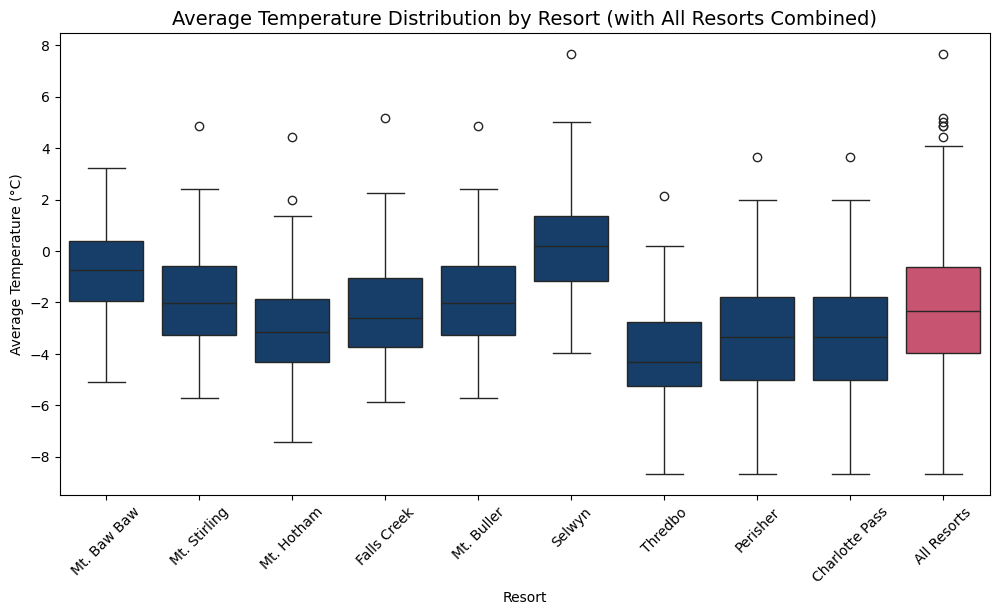

In [90]:
# Make sure avg_temp exists
if "avg_temp" not in df_general.columns:
    df_general["avg_temp"] = 0.75 * df_general["min_temp"] + 0.25 * df_general["max_temp"]

# Create a copy with an "All Resorts" label for combined data
df_all = df_general.copy()
df_all["resort"] = "All Resorts"

# Combine back
df_plot = pd.concat([df_general, df_all])

# Plot
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_plot, 
    x="resort", 
    y="avg_temp",
    palette=["#083D77" if r!="All Resorts" else "#DA4167" for r in df_plot["resort"].unique()]
)

plt.title("Average Temperature Distribution by Resort (with All Resorts Combined)", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Average Temperature (°C)")
plt.xlabel("Resort")
plt.show()

In [91]:
# Step 1: get min and max rain
rmin = predicted_data_2026["Rainfall amount (millimetres)"].min()
rmax = predicted_data_2026["Rainfall amount (millimetres)"].max()

# Step 2: scoring function
def rain_score_rule(r, rmin=rmin, rmax=rmax):
    if rmax == rmin:   # safeguard if no variation
        return 1.0     # neutral
    # linear decline from rmin (2 pts) to rmax (0 pts)
    return max(0.0, 2.0 * (1 - (r - rmin) / (rmax - rmin)))

# Step 3: Apply to rain column
predicted_data_2026["rain_score"] = predicted_data_2026["Rainfall amount (millimetres)"].apply(rain_score_rule)

# Preview
predicted_data_2026[["Resort","Year","week","Rainfall amount (millimetres)","rain_score"]].head()

,Resort,Year,week,Rainfall amount (millimetres),rain_score
0,Mt. Baw Baw,2026,1,72.528571,0.777363
1,Mt. Baw Baw,2026,2,10.507143,1.822878
2,Mt. Baw Baw,2026,3,55.971429,1.056472
3,Mt. Baw Baw,2026,4,97.150000,0.362312
4,Mt. Baw Baw,2026,5,86.542857,0.541120


In [92]:
predicted_data_2026["amenity_score"] = (predicted_data_2026["AmenityIndex"] * 2).clip(0, 2)

In [93]:
predicted_data_2026

,Year,week,Resort,Number of visitors,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),average_temp,Dates,nsw_school,...,nsw_public,vic_public,act_public,special_event,holiday_count,name,AmenityIndex,temp_score,rain_score,amenity_score
0,2026,1,Mt. Baw Baw,1257,3.742857,-1.960714,72.528571,-0.534821,9–15 Jun,0,...,1,1,1,0,3,Mt. Baw Baw,0.386287,2.000000,0.777363,0.772575
1,2026,2,Mt. Baw Baw,1826,7.425000,-3.510714,10.507143,-0.776786,16–22 Jun,0,...,0,0,0,0,0,Mt. Baw Baw,0.386287,2.000000,1.822878,0.772575
2,2026,3,Mt. Baw Baw,3556,6.842857,-3.171429,55.971429,-0.667857,23–29 Jun,0,...,0,0,0,0,1,Mt. Baw Baw,0.386287,2.000000,1.056472,0.772575
3,2026,4,Mt. Baw Baw,9084,9.617857,-3.653571,97.150000,-0.335714,30 Jun–6 Jul,0,...,0,0,0,0,1,Mt. Baw Baw,0.386287,2.000000,0.362312,0.772575
4,2026,5,Mt. Baw Baw,13001,8.300000,-1.775000,86.542857,0.743750,7–13 Jul,1,...,0,0,0,0,3,Mt. Baw Baw,0.386287,1.670162,0.541120,0.772575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,2026,11,Charlotte Pass,2507,9.476923,-4.494231,30.576923,-1.001442,18–24 Aug,0,...,0,0,0,0,0,Charlotte Pass,0.303815,2.000000,1.484555,0.607630
131,2026,12,Charlotte Pass,2188,11.042308,-1.448077,83.165385,1.674519,25–31 Aug,0,...,0,0,0,0,0,Charlotte Pass,0.303815,1.180025,0.598055,0.607630
132,2026,13,Charlotte Pass,1041,13.192308,-4.192308,20.450000,0.153846,1–7 Sep,0,...,0,0,0,1,1,Charlotte Pass,0.303815,1.980801,1.655268,0.607630
133,2026,14,Charlotte Pass,203,16.944231,-6.092308,18.738462,-0.333173,8–14 Sep,0,...,0,0,0,0,0,Charlotte Pass,0.303815,2.000000,1.684120,0.607630


In [94]:
# Define weights
w_school = 0.3
w_public = 0.5
w_special = 0.2

# Apply scoring rule
predicted_data_2026["holiday_score"] = predicted_data_2026.apply(
    lambda row: max(
        0,
        2
        - (row["nsw_school"] + row["vic_school"] + row["act_school"]) * w_school
        - (row["nsw_public"] + row["vic_public"] + row["act_public"]) * w_public
        - row["special_event"] * w_special
    ),
    axis=1
)


In [95]:
# Step 1: compute thresholds
q1 = predicted_data_2026["Number of visitors"].quantile(0.25)
q3 = predicted_data_2026["Number of visitors"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

# Step 2: define scoring rule
def visitor_score(n, q3=q3, upper_bound=upper_bound):
    if n > upper_bound:
        return 0.0       # extreme crowded outlier
    elif n > q3:
        return 1.0       # above Q3 = crowded
    else:
        return 2.0       # normal

# Step 3: apply
predicted_data_2026["visitor_score"] = predicted_data_2026["Number of visitors"].apply(visitor_score)

# Preview
predicted_data_2026[["Resort","Year","week","Number of visitors","visitor_score"]].head()

,Resort,Year,week,Number of visitors,visitor_score
0,Mt. Baw Baw,2026,1,1257,2.0
1,Mt. Baw Baw,2026,2,1826,2.0
2,Mt. Baw Baw,2026,3,3556,2.0
3,Mt. Baw Baw,2026,4,9084,2.0
4,Mt. Baw Baw,2026,5,13001,2.0


In [96]:
# List of component scores
score_cols = ["temp_score", "rain_score", "amenity_score", "holiday_score", "visitor_score"]

# Ensure all missing scores default to 0
for col in score_cols:
    if col not in predicted_data_2026.columns:
        predicted_data_2026[col] = 0

# predicted_data_2026 score = sum of all components
predicted_data_2026["predicted_data_2026_score"] = predicted_data_2026[score_cols].sum(axis=1)

# Preview top rows
predicted_data_2026[["Resort","Year","week"] + score_cols + ["predicted_data_2026_score"]].head()

,Resort,Year,week,temp_score,rain_score,amenity_score,holiday_score,visitor_score,predicted_data_2026_score
0,Mt. Baw Baw,2026,1,2.000000,0.777363,0.772575,0.5,2.0,6.049938
1,Mt. Baw Baw,2026,2,2.000000,1.822878,0.772575,2.0,2.0,8.595453
2,Mt. Baw Baw,2026,3,2.000000,1.056472,0.772575,1.7,2.0,7.529047
3,Mt. Baw Baw,2026,4,2.000000,0.362312,0.772575,1.7,2.0,6.834887
4,Mt. Baw Baw,2026,5,1.670162,0.541120,0.772575,1.1,2.0,6.083857


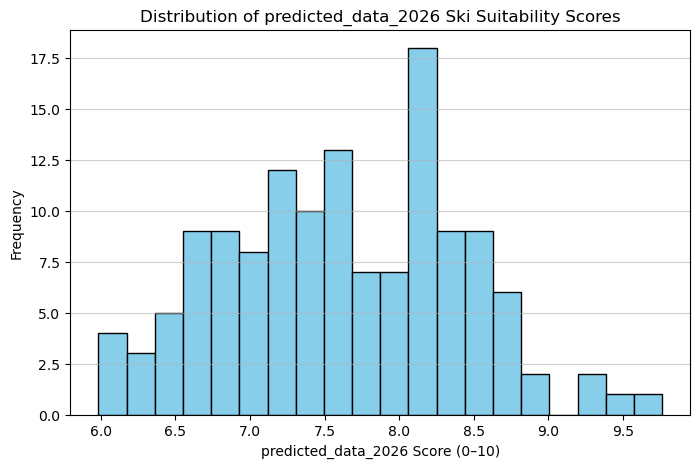

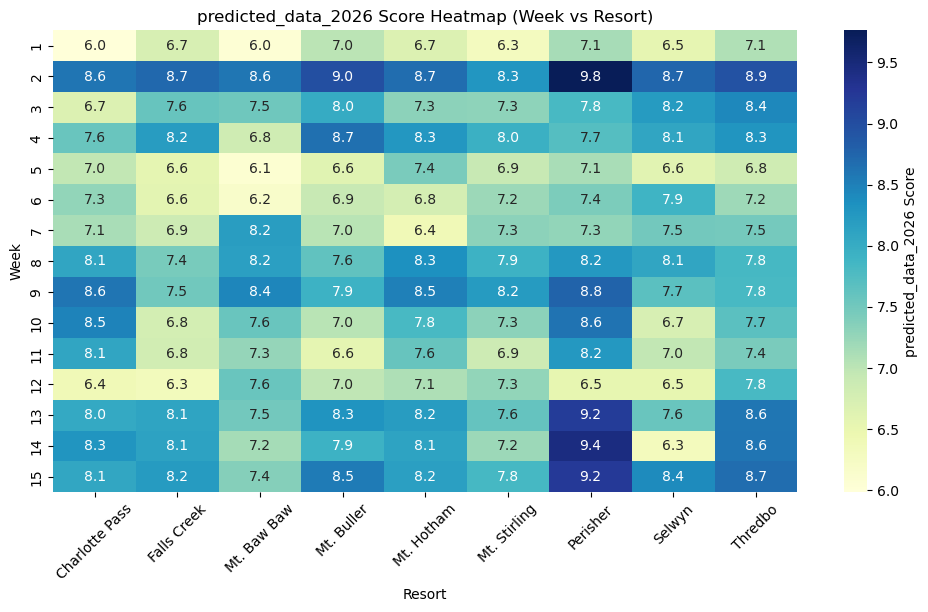

In [97]:

# 1) Histogram of predicted_data_2026 scores
plt.figure(figsize=(8,5))
plt.hist(predicted_data_2026["predicted_data_2026_score"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of predicted_data_2026 Ski Suitability Scores")
plt.xlabel("predicted_data_2026 Score (0–10)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.6)
plt.show()

# 3) Heatmap (week × resort)
pivot = predicted_data_2026.pivot_table(index="week", columns="Resort", values="predicted_data_2026_score", aggfunc="mean")
plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'predicted_data_2026 Score'})
plt.title("predicted_data_2026 Score Heatmap (Week vs Resort)")
plt.xlabel("Resort")
plt.xticks(rotation=45)
plt.ylabel("Week")
plt.show()

In [98]:
# Find row with the highest predicted_data_2026_score
best_row = predicted_data_2026.loc[predicted_data_2026["predicted_data_2026_score"].idxmax()]

# Print all attributes
print(best_row)

Year                                   2026
week                                      2
Resort                             Perisher
Number of visitors                    11387
Maximum temperature (Degree C)     7.578571
Minimum temperature (Degree C)    -8.646429
Rainfall amount (millimetres)           0.0
average_temp                      -4.590179
Dates                             16–22 Jun
nsw_school                                0
vic_school                                0
act_school                                0
nsw_public                                0
vic_public                                0
act_public                                0
special_event                             0
holiday_count                             0
name                               Perisher
AmenityIndex                       0.881818
temp_score                              2.0
rain_score                              2.0
amenity_score                      1.763636
holiday_score                   

## EDA

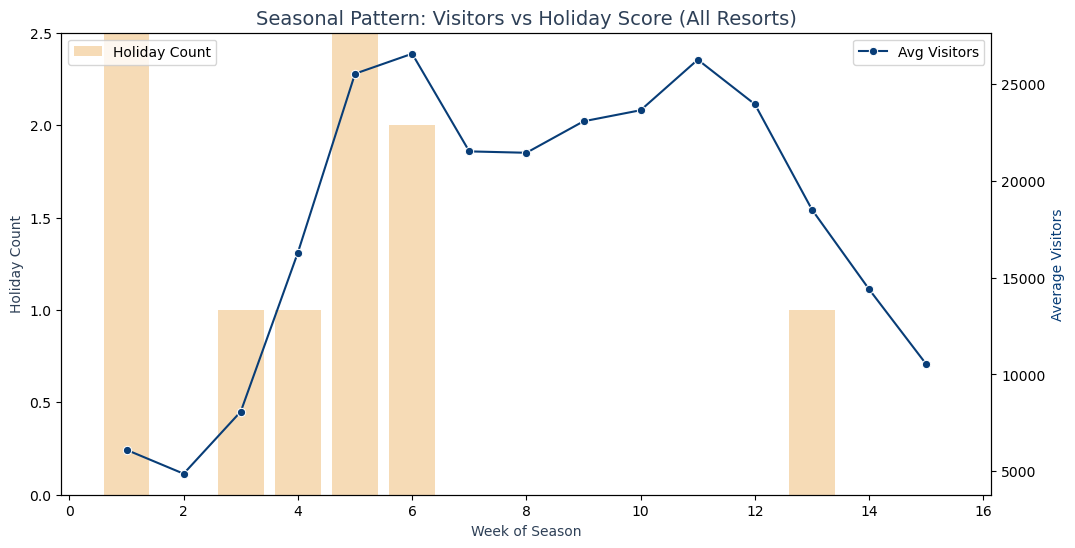

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Aggregate weekly averages ---
seasonal = df_general.groupby("week").agg({
    "num_passenger": "mean",
    "holiday_count": "max"
}).reset_index()

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12,6))

# Bar chart for holiday score (Sunset)
ax1.bar(seasonal["week"], seasonal["holiday_count"], 
        color="#F6D8AE", alpha=0.9, label="Holiday Count")
ax1.set_ylabel("Holiday Count", color="#2E4057")  # Charcoal for text
ax1.set_ylim(0, 2.5)

# Line chart for visitors (Yale Blue)
ax2 = ax1.twinx()
sns.lineplot(data=seasonal, x="week", y="num_passenger", 
             marker="o", color="#083D77", ax=ax2, label="Avg Visitors")
ax2.set_ylabel("Average Visitors", color="#083D77")

# Titles + styling
plt.title("Seasonal Pattern: Visitors vs Holiday Score (All Resorts)", 
          fontsize=14, color="#2E4057")
ax1.set_xlabel("Week of Season", color="#2E4057")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")


/var/folders/qb/1whh5bv901bb76kjzsnqrk2c0000gn/T/ipykernel_27829/2863192321.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


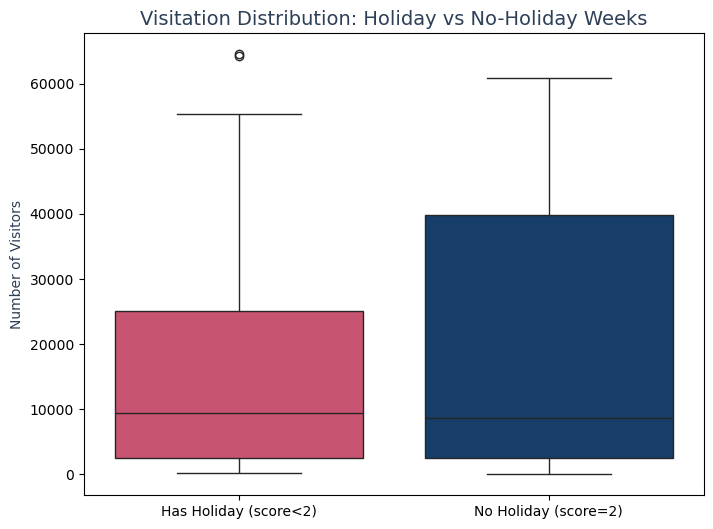

holiday_group
No Holiday (score=2)     81
Has Holiday (score<2)    54
Name: count, dtype: int64


In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# palette
COL_RED   = "#DA4167"  # holiday
COL_BLUE  = "#083D77"  # no holiday
COL_TEXT  = "#2E4057"

# Label groups correctly
predicted_data_2026["holiday_group"] = np.where(predicted_data_2026["holiday_score"] < 2.0,
                                "Has Holiday (score<2)",
                                "No Holiday (score=2)")

# Put "Has Holiday" on the left
order = pd.Categorical(predicted_data_2026["holiday_group"],
                       categories=["Has Holiday (score<2)", "No Holiday (score=2)"],
                       ordered=True)
predicted_data_2026["holiday_group"] = order

# Plot
plt.figure(figsize=(8,6))
sns.boxplot(
    data=predicted_data_2026,
    x="holiday_group",
    y="Number of visitors",
    palette={
        "Has Holiday (score<2)" : COL_RED,
        "No Holiday (score=2)"  : COL_BLUE
    }
)
plt.title("Visitation Distribution: Holiday vs No-Holiday Weeks", fontsize=14, color=COL_TEXT)
plt.xlabel("")
plt.ylabel("Number of Visitors", color=COL_TEXT)
plt.show()

# (optional) sanity check counts
print(predicted_data_2026["holiday_group"].value_counts())

In [101]:
df_general

,year,week,resort,num_passenger,price,station,max_temp,min_temp,rain,average_temp,Dates,nsw_school,vic_school,act_school,nsw_public,vic_public,act_public,special_event,holiday_count,avg_temp
0,2014,1,Mt. Baw Baw,555.0,79,85291,7.3,-2.2,3.485714,0.175,9–15 Jun,0,0,0,1,1,1,0,3,0.175
1,2014,2,Mt. Baw Baw,804.0,79,85291,8.6,-1.0,3.000000,1.400,16–22 Jun,0,0,0,0,0,0,0,0,1.400
2,2014,3,Mt. Baw Baw,993.0,79,85291,2.5,-4.5,12.733333,-2.750,23–29 Jun,0,1,0,0,0,0,0,1,-2.750
3,2014,4,Mt. Baw Baw,2976.0,79,85291,6.2,-2.6,11.714286,-0.400,30 Jun–6 Jul,0,1,0,0,0,0,0,1,-0.400
4,2014,5,Mt. Baw Baw,11112.0,79,85291,4.7,-3.7,11.800000,-1.600,7–13 Jul,1,1,1,0,0,0,0,3,-1.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,2024,11,Charlotte Pass,2667.0,175,71075,8.5,-4.6,4.200000,-1.325,18–24 Aug,0,0,0,0,0,0,0,0,-1.325
1481,2024,12,Charlotte Pass,2392.0,175,71075,10.5,-1.7,15.466667,1.350,25–31 Aug,0,0,0,0,0,0,0,0,1.350
1482,2024,13,Charlotte Pass,1323.0,175,71075,12.6,-4.0,5.857143,0.150,1–7 Sep,0,0,0,0,0,0,1,1,0.150
1483,2024,14,Charlotte Pass,454.0,175,71075,14.7,-6.6,0.900000,-1.275,8–14 Sep,0,0,0,0,0,0,0,0,-1.275


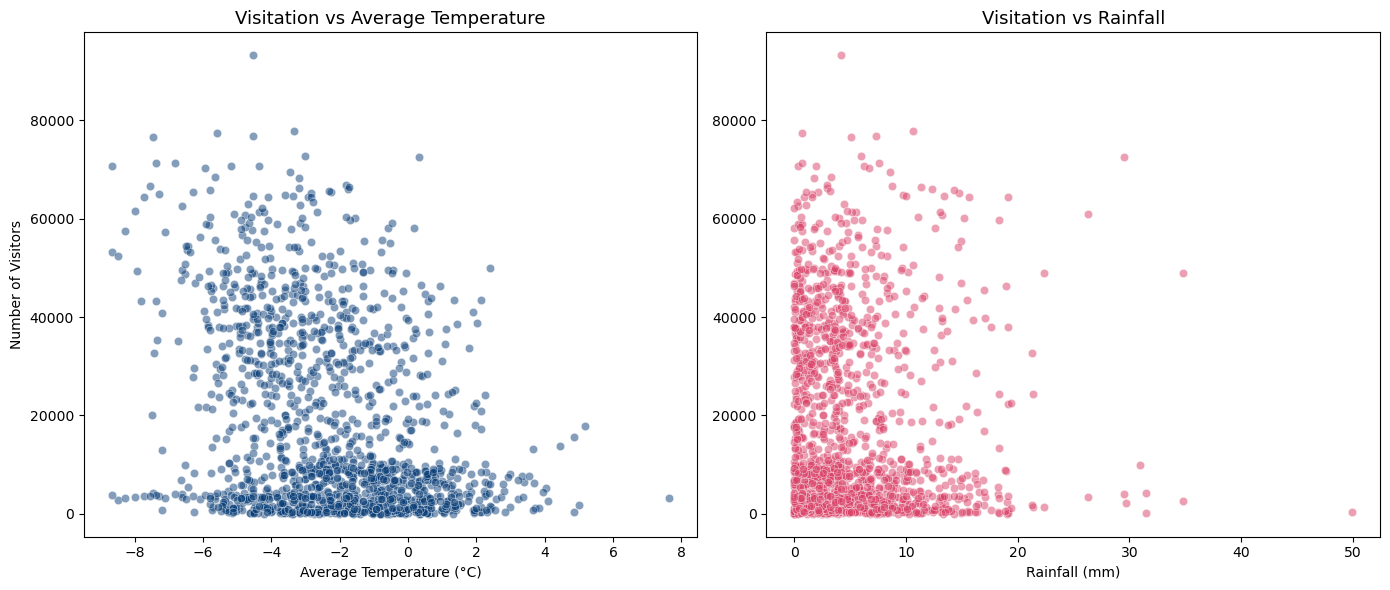

Pearson  Temp vs Visitors: -0.333
Pearson  Rain vs Visitors: -0.072
Spearman Temp vs Visitors: -0.290
Spearman Rain vs Visitors: -0.117


In [102]:
# -----------------------------
# 2) Climate impacts (scatter + correlations)
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# temp vs visitors
sns.scatterplot(data=df_general, x="average_temp", y="num_passenger", 
                alpha=0.5, color="#083D77", ax=axes[0])
axes[0].set_title("Visitation vs Average Temperature", fontsize=13, color="BLACK")
axes[0].set_xlabel("Average Temperature (°C)")
axes[0].set_ylabel("Number of Visitors")

# rain vs visitors
sns.scatterplot(data=df_general, x="rain", y="num_passenger", 
                alpha=0.5, color="#DA4167", ax=axes[1])
axes[1].set_title("Visitation vs Rainfall", fontsize=13, color="BLACK")
axes[1].set_xlabel("Rainfall (mm)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

# correlations (both Pearson + Spearman)
pearson_temp  = df_general["average_temp"].corr(df_general["num_passenger"])
pearson_rain  = df_general["rain"].corr(df_general["num_passenger"])
spearman_temp = df_general["average_temp"].corr(df_general["num_passenger"], method="spearman")
spearman_rain = df_general["rain"].corr(df_general["num_passenger"], method="spearman")

print(f"Pearson  Temp vs Visitors: {pearson_temp:.3f}")
print(f"Pearson  Rain vs Visitors: {pearson_rain:.3f}")
print(f"Spearman Temp vs Visitors: {spearman_temp:.3f}")
print(f"Spearman Rain vs Visitors: {spearman_rain:.3f}")